# Generación de paleta de colores a partir de imágenesiones.iones.

## 1. Exploración y perfilamiento de los datos

### 1.1 Se importan las librerías necesarias
Se importan las librerías `Pandas`,`Numpy` `scikit-learn` y `matplotlib`.

In [13]:
import matplotlib.pyplot as plt
import os
import cv2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

In [15]:
# Ruta de la carpeta con imágenes
folder_path = "./images"

In [17]:

# Leer la única imagen en la carpeta
archivo = os.listdir(folder_path)[0]  # Tomar el primer archivo
img_path = os.path.join(folder_path, archivo)

# Cargar y procesar la imagen
img = cv2.imread(img_path)
img = cv2.resize(img, (500, 500))  # Redimensionar
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB

# Convertir a matriz de píxeles (N, 3)
datos_pixeles = img.reshape(-1, 3)



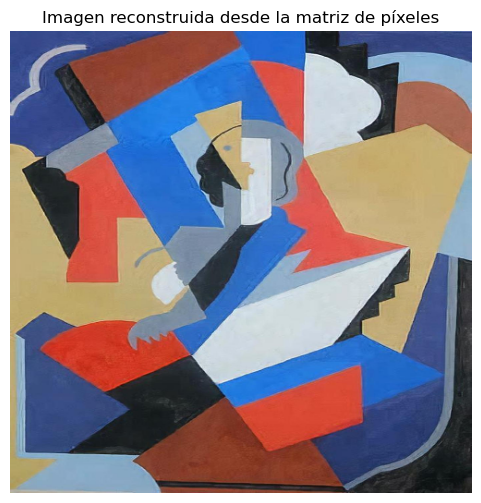

In [19]:
# Mostrar la imagen original reconstruida desde `datos_pixeles`
imagen_recuperada = datos_pixeles.reshape((500, 500, 3))  # Volver a la forma original

plt.figure(figsize=(6, 6))
plt.imshow(imagen_recuperada)
plt.axis("off")
plt.title("Imagen reconstruida desde la matriz de píxeles")
plt.show()

In [21]:
# Normalizar los valores RGB al rango [0, 1]
datos_pixeles = datos_pixeles / 255.0

print(f"Forma de la matriz de píxeles: {datos_pixeles.shape}")  # Debería ser (N, 3)
print(f"Ejemplo de valores normalizados: {datos_pixeles[:5]}")  # Muestra 5 píxeles normalizados

Forma de la matriz de píxeles: (250000, 3)
Ejemplo de valores normalizados: [[0.20784314 0.28235294 0.54117647]
 [0.20784314 0.28235294 0.54117647]
 [0.20784314 0.28235294 0.54117647]
 [0.20784314 0.28235294 0.54117647]
 [0.20784314 0.28235294 0.54117647]]


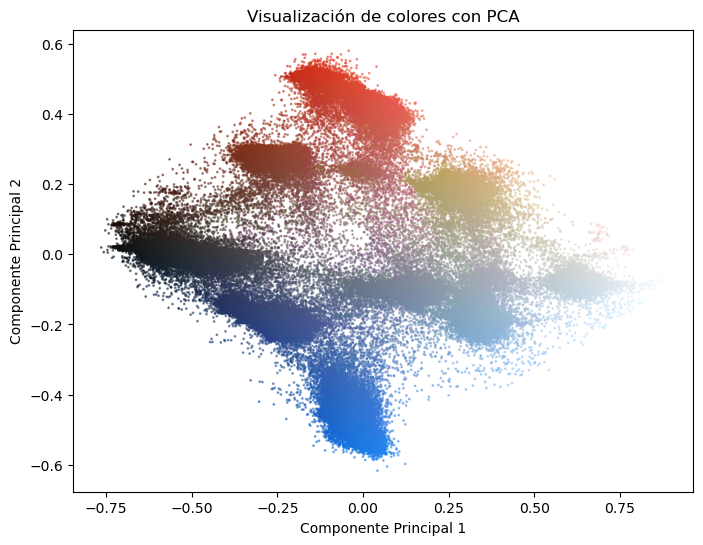

In [23]:
# Aplicar PCA para reducir de 3D (RGB) a 2D
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(datos_pixeles)

# Graficar los datos reducidos
plt.figure(figsize=(8, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], s=1, c=datos_pixeles, alpha=0.5)
plt.title("Visualización de colores con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

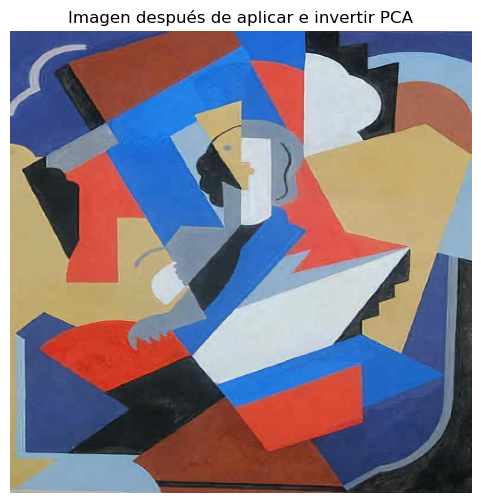

In [24]:
# Invertir PCA para recuperar los datos en el espacio original
x_recovered = pca.inverse_transform(x_reduced)

# Desnormalizar los valores (volver de [0,1] a [0,255])
x_recovered = (x_recovered * 255).astype(np.uint8)

num_imagenes = len(os.listdir(folder_path))
tamaño_img = (500, 500, 3)

# Separar los datos reconstruidos en imágenes individuales
imagenes_recuperadas = np.split(x_recovered, num_imagenes)  

# Mostrar la única imagen reconstruida
plt.figure(figsize=(6, 6))
plt.imshow(imagen_recuperada.reshape(tamaño_img))  # Asegurarse de que está en la forma correcta
plt.axis("off")
plt.title("Imagen después de aplicar e invertir PCA")
plt.show()


### 2. Desarrollo de los modelos de agrupación para identificar los colores presentes en las imágenes

Para identifica los clores presentes en las imágenes se entrenarán dos modelos no supervisados: K-means y Meanshift; para los cuales se realizará la búsqueda de los respectivos hiperparámetros que mejor se adecuan a cada imagen.

#### 2.1 Algoritmo K-means

K-Means es un algoritmo de clustering que agrupa los píxeles en un número específico de clusters, en este caso colores representativos. Por lo cual, el hiperparámetro a encontrar es es mejor número de cluster. Para ello, se crea una función para encontrar el mejor número de clusters mediante el método de la silueta con `silhouette_score`.

In [49]:
def optimal_kmeans(x_reduced, k_min=2, k_max=5):
    # Rango de valores para n_clusters
    n_clusters_range = range(k_min, k_max)
    
    # Almacenar resultados
    resultados_kmeans = []
    
    # Búsqueda de hiperparámetros
    for n_clusters in n_clusters_range:
        # Aplicar K-Means en el espacio reducido
        kmeans = KMeans(init='k-means++',max_iter=300,n_clusters=n_clusters, random_state=42)
        kmeans.fit(x_reduced)
        
        # Calcular el silhouette score
        silhouette = silhouette_score(x_reduced, kmeans.labels_)
        resultados_kmeans.append((n_clusters, silhouette))
    return resultados_kmeans
    

Utilizando la función `optimal_kmeans` con un rango desde 3 hasta 6, se gráfican los valores obtenidos por el método de la silueta.

In [52]:
# Mostrar resultados
resultados_kmeans_df = pd.DataFrame(optimal_kmeans(x_reduced, 3, 7), columns=["n_clusters", "silhouette_score"])
print("Resultados de la búsqueda de hiperparámetros para K-Means:")
print(resultados_kmeans_df)

Resultados de la búsqueda de hiperparámetros para K-Means:
   n_clusters  silhouette_score
0           3          0.499313
1           4          0.484612
2           5          0.551282
3           6          0.561824


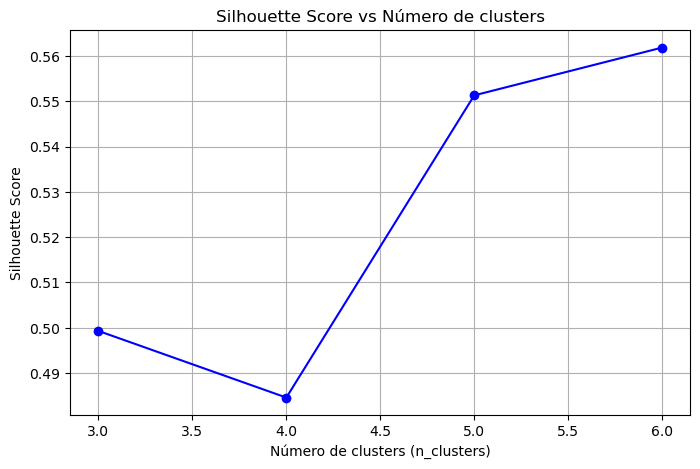

In [57]:
# Graficar el silhouette score
plt.figure(figsize=(8, 5))
plt.plot(range(3, 7), resultados_kmeans_df["silhouette_score"], marker='o', linestyle='-', color='b')
plt.xlabel("Número de clusters (n_clusters)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Número de clusters")
plt.grid(True)
plt.show()

Se selecciona el mejor valor de `n_clusters` como el valor máximo en el conjunto obtenido con la función `optimal_kmeans`.

In [60]:
mejor_n_clusters = resultados_kmeans_df.loc[resultados_kmeans_df["silhouette_score"].idxmax(), "n_clusters"]
print(f"Mejor número de clusters: {mejor_n_clusters}")

Mejor número de clusters: 6


Conociendo el mejor `n_clusters`, se entrena el modelo final de K-means para obtener la paleta de color de la imagen. Para esto, de debe invertir PCA utilizando `pca.inverse_transform`.

In [63]:
# Entrenar el modelo final con el mejor n_clusters
kmeans_final = KMeans(n_clusters=mejor_n_clusters, random_state=77)
kmeans_final.fit(x_reduced)

# Obtener los centroides en el espacio reducido
centroides_reducidos = kmeans_final.cluster_centers_

# Recuperar los colores originales usando PCA inversa
centroides_rgb = pca.inverse_transform(centroides_reducidos)

# Los valores deben estar en el rango [0, 1]
centroides_rgb = np.clip(centroides_rgb, 0, 1)

Por último, se genera la paleta de colores para la imagen seleccionada.

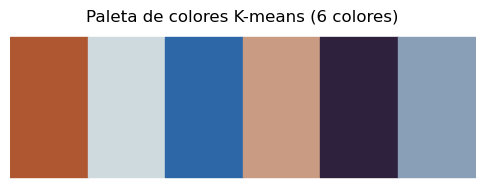

In [66]:
plt.figure(figsize=(6, 2))
for i, color in enumerate(centroides_rgb):
    plt.fill_between([i, i+1], 0, 1, color=color)
plt.xlim(0, mejor_n_clusters)
plt.axis("off")
plt.title(f"Paleta de colores K-means ({mejor_n_clusters} colores)")
plt.show()

#### 2.2 Algoritmo Mean Shift

Por otra parte, Mean Shift es un algoritmo de agrupación que considera el espacio de caracteristicas como una función de densidad de probabilidad. Por lo que, en este caso no se requiere especificar el número de clusters, pero se realiza la busqueda del ancho de banda (`bandwidth`), utilizando el método de la silueta.

In [27]:
def optimal_meanshift(x_reduced, bandwidth_range = np.arange(0.05, 0.5, 0.05)):
    # Almacenar resultados
    resultados_meanshift = []

    # Búsqueda de hiperparámetros
    for bandwidth in bandwidth_range:
        meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True,max_iter=300)
        meanshift.fit(x_reduced)
        if len(np.unique(meanshift.labels_)) > 1:
            silhouette = silhouette_score(x_reduced, meanshift.labels_)
            resultados_meanshift.append((bandwidth, silhouette))
    return resultados_meanshift

Utilizando la función `optimal_meanshifts` con un rango de 0.05 a 0.5 en pasos de 0.05, se gráfican los valores obtenidos por el método de la silueta.

In [30]:
# Mostrar resultados
resultados_meanshift_df = pd.DataFrame(optimal_meanshift(x_reduced), columns=["bandwidth", "silhouette"])
print("Resultados de Mean Shift:")
print(resultados_meanshift_df)

Resultados de Mean Shift:
   bandwidth  silhouette
0       0.05    0.582360
1       0.10    0.705688
2       0.15    0.706096
3       0.20    0.694498
4       0.25    0.591300
5       0.30    0.511896
6       0.35    0.516491
7       0.40    0.439155


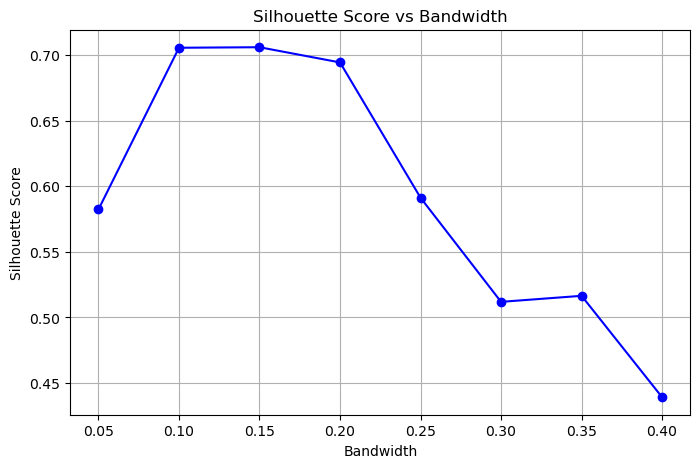

In [31]:
# Graficar el silhouette score
plt.figure(figsize=(8, 5))
plt.plot(resultados_meanshift_df["bandwidth"], resultados_meanshift_df["silhouette"], marker='o', linestyle='-', color='b')
plt.xlabel("Bandwidth")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Bandwidth")
plt.grid(True)
plt.show()

Se selecciona el mejor valor de `bandwidth` como el valor máximo en el conjunto obtenido con la función `optimal_meanshifts`.

In [33]:
mejor_bandwidth = resultados_meanshift_df.loc[resultados_meanshift_df["silhouette"].idxmax(), "bandwidth"]

Conociendo el mejor `bandwidth`, se entrena el modelo final de Mean Shift para obtener la paleta de color de la imagen.

In [42]:
# Entrenar el modelo final con el mejor bandwidth
meanshift_final = MeanShift(bandwidth=mejor_bandwidth, bin_seeding=True)
meanshift_final.fit(x_reduced)

# Obtener los centroides en el espacio reducido
centroides_reducidos = meanshift_final.cluster_centers_

# Recuperar los colores originales usando PCA inversa
centroides_rgb = pca.inverse_transform(centroides_reducidos)

Por último, se genera la paleta de colores para la imagen seleccionada.

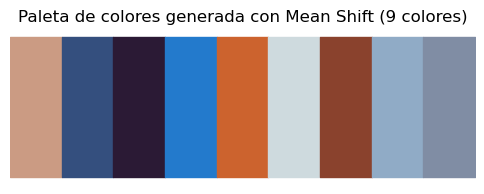

In [43]:
plt.figure(figsize=(6, 2))
for i, color in enumerate(centroides_rgb):
    plt.fill_between([i, i+1], 0, 1, color=color)
plt.xlim(0, len(centroides_rgb))
plt.axis("off")
plt.title(f"Paleta de colores generada con Mean Shift ({len(centroides_rgb)} colores)")
plt.show()

#### 2.3 Comparación de resultados